In [1]:
import os
import json
import numpy as np
import tensorflow as tf
import cv2
from tensorflow.keras.utils import Sequence
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [2]:
class BrainTumorDataset(Sequence):
    def __init__(self, json_file, root_dir, batch_size=4, image_size=(256, 256)):
        self.root_dir = root_dir
        self.batch_size = batch_size
        self.image_size = image_size

        with open(json_file) as f:
            self.data = json.load(f)

        self.image_keys = list(self.data.keys())

    def __len__(self):
        return len(self.image_keys) // self.batch_size

    def __getitem__(self, idx):
        batch_keys = self.image_keys[idx * self.batch_size:(idx + 1) * self.batch_size]
        images, masks = [], []

        for key in batch_keys:
            image_info = self.data[key]
            file_name = image_info['filename']
            file_path = os.path.join(self.root_dir, file_name)

            image = load_img(file_path, target_size=self.image_size)
            image = img_to_array(image) / 255.0

            mask = np.zeros(self.image_size, dtype=np.uint8)

            for region in image_info['regions']:
                shape_attributes = region['shape_attributes']
                if shape_attributes['name'] == 'polygon':
                    points_x = shape_attributes['all_points_x']
                    points_y = shape_attributes['all_points_y']
                    points = np.array(list(zip(points_x, points_y)), dtype=np.int32)
                    cv2.fillPoly(mask, [points], 1)
                elif shape_attributes['name'] == 'ellipse':
                    center_x = int(shape_attributes['cx'])
                    center_y = int(shape_attributes['cy'])
                    radius_x = int(shape_attributes['rx'])
                    radius_y = int(shape_attributes['ry'])
                    angle = shape_attributes.get('theta', 0) * (180.0 / np.pi)
                    cv2.ellipse(mask, (center_x, center_y), (radius_x, radius_y), angle, 0, 360, 1, -1)

            mask = cv2.resize(mask, self.image_size)
            mask = np.expand_dims(mask, axis=-1)

            images.append(image)
            masks.append(mask)

        return np.array(images), np.array(masks)

In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, BatchNormalization, ReLU, Add, UpSampling2D, Concatenate, GlobalAveragePooling2D, Reshape, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50

In [4]:
class ASPP(tf.keras.layers.Layer):
    def __init__(self, out_channels):
        super(ASPP, self).__init__()
        self.conv1 = Conv2D(out_channels, kernel_size=1)
        self.conv2 = Conv2D(out_channels, kernel_size=3, padding='same', dilation_rate=2)
        self.conv3 = Conv2D(out_channels, kernel_size=3, padding='same', dilation_rate=4)
        self.conv4 = Conv2D(out_channels, kernel_size=3, padding='same', dilation_rate=8)
        self.conv5 = Conv2D(out_channels, kernel_size=1)

    def call(self, x):
        feat1 = self.conv1(x)
        feat2 = self.conv2(x)
        feat3 = self.conv3(x)
        feat4 = self.conv4(x)
        
        feat5 = GlobalAveragePooling2D()(x)
        feat5 = Reshape((1, 1, x.shape[-1]))(feat5)
        feat5 = UpSampling2D(size=(x.shape[1], x.shape[2]), interpolation='bilinear')(feat5)
        feat5 = self.conv5(feat5)
        
        return Concatenate()([feat1, feat2, feat3, feat4, feat5])

class AttentionBlock(tf.keras.layers.Layer):
    def __init__(self, F_g, F_l, F_int):
        super(AttentionBlock, self).__init__()
        self.W_g = Conv2D(F_int, kernel_size=1)
        self.W_x = Conv2D(F_int, kernel_size=1)
        self.psi = Conv2D(1, kernel_size=1)
        self.relu = ReLU()
        self.sigmoid = tf.keras.activations.sigmoid

    def call(self, g, x):
        g1 = self.W_g(g)
        x1 = self.W_x(x)
        psi = self.relu(g1 + x1)
        psi = self.sigmoid(self.psi(psi))
        return x * psi

class ATRASUNet(tf.keras.Model):
    def __init__(self, n_classes=1):
        super(ATRASUNet, self).__init__()

        base_model = ResNet50(include_top=False, weights='imagenet', input_shape=(256, 256, 3))
        self.encoder = Model(inputs=base_model.input, outputs=[
            base_model.get_layer('conv1_relu').output,
            base_model.get_layer('conv2_block3_out').output,
            base_model.get_layer('conv3_block4_out').output,
            base_model.get_layer('conv4_block6_out').output
        ])
        
        self.aspp = ASPP(256)
        
        self.dec4 = self.decoder_block(2048 + 256, 128)
        self.att4 = AttentionBlock(256, 2048, 256)
        
        self.dec3 = self.decoder_block(1280, 64)
        self.att3 = AttentionBlock(128, 1024, 128)
        
        self.dec2 = self.decoder_block(576, 32)
        self.att2 = AttentionBlock(64, 512, 64)
        
        self.dec1 = self.decoder_block(288, 32)
        self.att1 = AttentionBlock(64, 256, 32)

        self.final_conv = Conv2D(n_classes, kernel_size=1, activation='sigmoid')

    def decoder_block(self, in_channels, out_channels):
        return tf.keras.Sequential([
            Conv2D(out_channels, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            Conv2D(out_channels, kernel_size=3, padding='same'),
            BatchNormalization(),
            ReLU(),
            UpSampling2D(size=(2, 2), interpolation='bilinear')
        ])

    def call(self, inputs):
        e1, e2, e3, e4 = self.encoder(inputs)

        aspp = self.aspp(e4)

        d4 = self.dec4(tf.concat([aspp, self.att4(aspp, e4)], axis=-1))
        d3 = self.dec3(tf.concat([d4, self.att3(d4, e3)], axis=-1))
        d2 = self.dec2(tf.concat([d3, self.att2(d3, e2)], axis=-1))
        d1 = self.dec1(tf.concat([d2, self.att1(d2, e1)], axis=-1))

        out = self.final_conv(d1)
        return out

In [5]:
# Building the model
input_shape = (256, 256, 3)
inputs = Input(shape=input_shape)
outputs = ATRASUNet(n_classes=1)(inputs)
model = Model(inputs, outputs)

In [6]:
import os
import tensorflow as tf
from tensorflow.keras import backend as K

# Define the loss and metric functions
def dice_loss(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(tf.cast(y_true, tf.float32))
    y_pred_f = K.flatten(tf.cast(y_pred, tf.float32))
    intersection = K.sum(y_true_f * y_pred_f)
    return 1 - (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def bce_dice_loss(y_true, y_pred):
    y_true = tf.cast(y_true, tf.float32)
    bce = tf.keras.losses.BinaryCrossentropy(from_logits=False)(y_true, y_pred)
    dice = dice_loss(y_true, y_pred)
    return bce + dice

def iou_metric(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    intersection = tf.reduce_sum(tf.cast(y_true * y_pred, tf.float32))
    union = tf.reduce_sum(tf.cast(y_true + y_pred, tf.float32)) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def accuracy_metric(y_true, y_pred, threshold=0.5):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    correct_predictions = tf.equal(y_true, y_pred)
    accuracy = tf.reduce_mean(tf.cast(correct_predictions, tf.float32))
    return accuracy

In [7]:
# Dataset and training configuration
batch_size = 4
num_epochs = 50

train_root_dir = 'TRAIN'
train_json_file = os.path.join(train_root_dir, "annotations_train.json")
val_root_dir = 'VAL'
val_json_file = os.path.join(val_root_dir, "annotations_val.json")

# Assuming BrainTumorDataset is a custom Dataset class
train_dataset = BrainTumorDataset(train_json_file, train_root_dir, batch_size=batch_size)
val_dataset = BrainTumorDataset(val_json_file, val_root_dir, batch_size=batch_size)

# Model compilation
optimizer = tf.keras.optimizers.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[iou_metric, accuracy_metric])

# Model training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

Epoch 1/50


C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


125/125 ━━━━━━━━━━━━━━━━━━━━ 224s 2s/step - accuracy_metric: 0.9022 - iou_metric: 0.0861 - loss: 1.2552 - val_accuracy_metric: 0.9343 - val_iou_metric: 0.0037 - val_loss: 1.4281
Epoch 2/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 204s 2s/step - accuracy_metric: 0.9288 - iou_metric: 0.3416 - loss: 1.0954 - val_accuracy_metric: 0.9224 - val_iou_metric: 0.0204 - val_loss: 1.2905
Epoch 3/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 200s 2s/step - accuracy_metric: 0.9551 - iou_metric: 0.5469 - loss: 0.9156 - val_accuracy_metric: 0.9173 - val_iou_metric: 0.0911 - val_loss: 1.2282
Epoch 4/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 206s 2s/step - accuracy_metric: 0.9776 - iou_metric: 0.6781 - loss: 0.8180 - val_accuracy_metric: 0.9164 - val_iou_metric: 0.1567 - val_loss: 1.1827
Epoch 5/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 195s 2s/step - accuracy_metric: 0.9815 - iou_metric: 0.7345 - loss: 0.7178 - val_accuracy_metric: 0.9197 - val_iou_metric: 0.1407 - val_loss: 1.1618
Epoch 6/50
125/125 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy_me

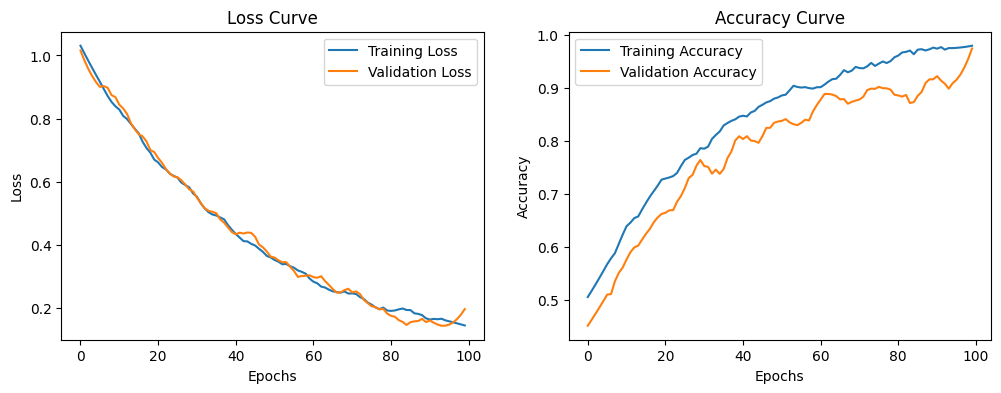

In [6]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss curves
def plot_history(history):
    # Extracting accuracy and loss for both training and validation sets
    train_accuracy = history.history.get('accuracy_metric')
    val_accuracy = history.history.get('val_accuracy_metric')
    train_loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')

    epochs = range(1, len(train_accuracy) + 1)

    # Plotting training and validation accuracy
    plt.figure(figsize=(14, 6))
    
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_accuracy, label='Training Accuracy')
    plt.plot(epochs, val_accuracy, label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plotting training and validation loss
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_loss, label='Training Loss')
    plt.plot(epochs, val_loss, label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()

# Call the function to plot the curves
plot_history(history)


In [10]:
# Evaluate on the training set
train_iou_scores = model.evaluate(train_dataset, verbose=1)
print(f"Average IoU for the training set: {train_iou_scores[1]:.4f}")

# Evaluate on the validation set
val_iou_scores = model.evaluate(val_dataset, verbose=1)
print(f"Average IoU for the validation set: {val_iou_scores[1]:.4f}")

125/125 ━━━━━━━━━━━━━━━━━━━━ 45s 359ms/step - accuracy_metric: 0.9871 - iou_metric: 0.7897 - loss: 0.3457
Average IoU for the training set: 0.8050
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 377ms/step - accuracy_metric: 0.9551 - iou_metric: 0.3917 - loss: 0.7325
Average IoU for the validation set: 0.3341


In [11]:
# Evaluate on the test set
test_root_dir = 'TEST'
test_json_file = os.path.join(test_root_dir, "annotations_test.json")

test_dataset = BrainTumorDataset(test_json_file, test_root_dir, batch_size=batch_size)

test_iou_scores = model.evaluate(test_dataset, verbose=1)
print(f"Average IoU for the test set: {test_iou_scores[1]:.4f}")

C:\Users\Amlan Anupam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 336ms/step - accuracy_metric: 0.9568 - iou_metric: 0.4235 - loss: 0.7006
Average IoU for the test set: 0.4236


In [12]:
# Visualization function
def visualize_predictions(model, dataset, num_images=3):
    for i in range(num_images):
        images, masks = dataset[i]
        predictions = model.predict(images)

        for j in range(len(images)):
            fig, axes = plt.subplots(1, 3, figsize=(15, 5))

            image = images[j]
            mask = masks[j].squeeze()
            prediction = predictions[j].squeeze()

            axes[0].imshow(image)
            axes[0].set_title("Original Image")
            axes[0].axis("off")

            axes[1].imshow(mask, cmap="gray")
            axes[1].set_title("Ground Truth Mask")
            axes[1].axis("off")

            axes[2].imshow(prediction, cmap="gray")
            axes[2].set_title("Predicted Mask")
            axes[2].axis("off")

            plt.show()

Visualizing predictions for the training set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


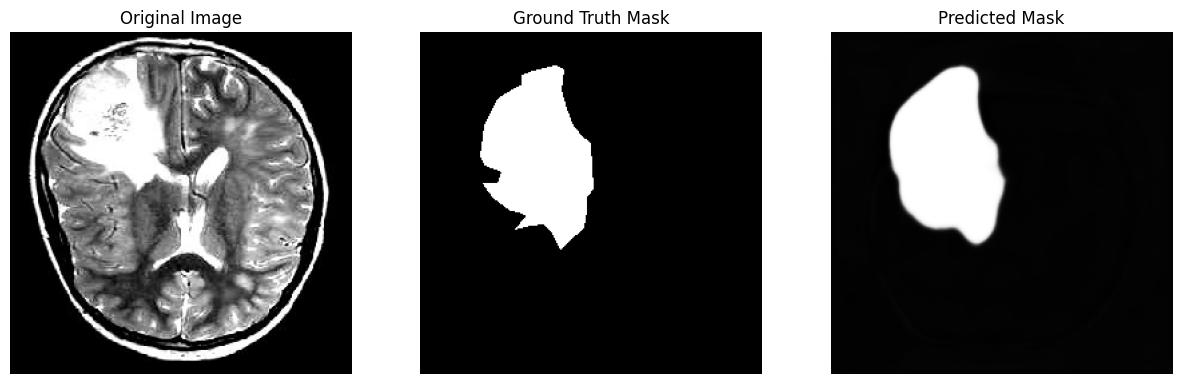

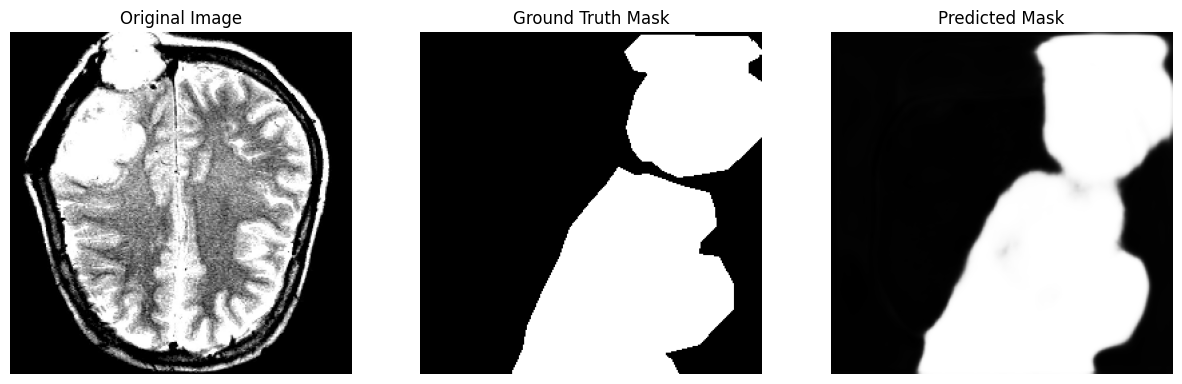

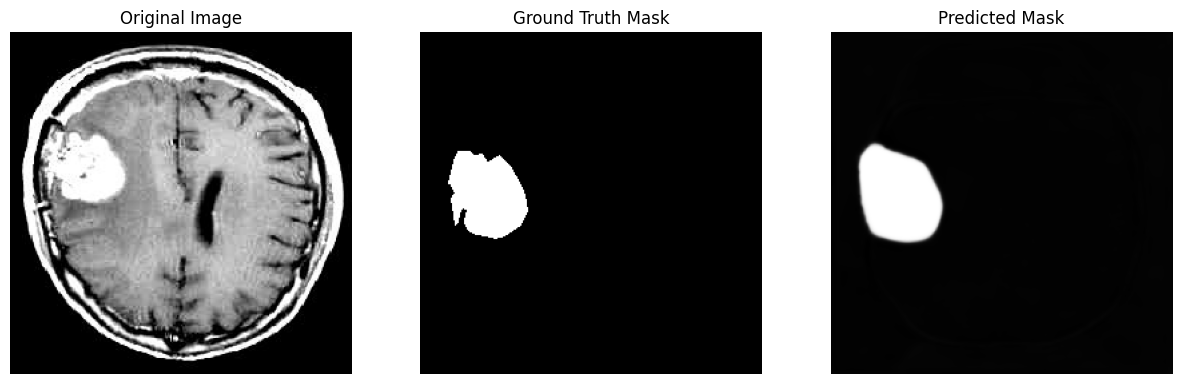

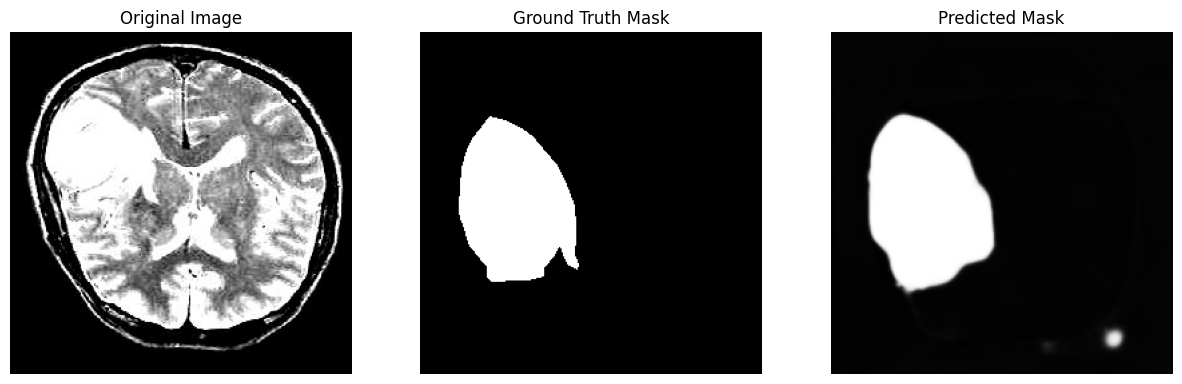

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 418ms/step


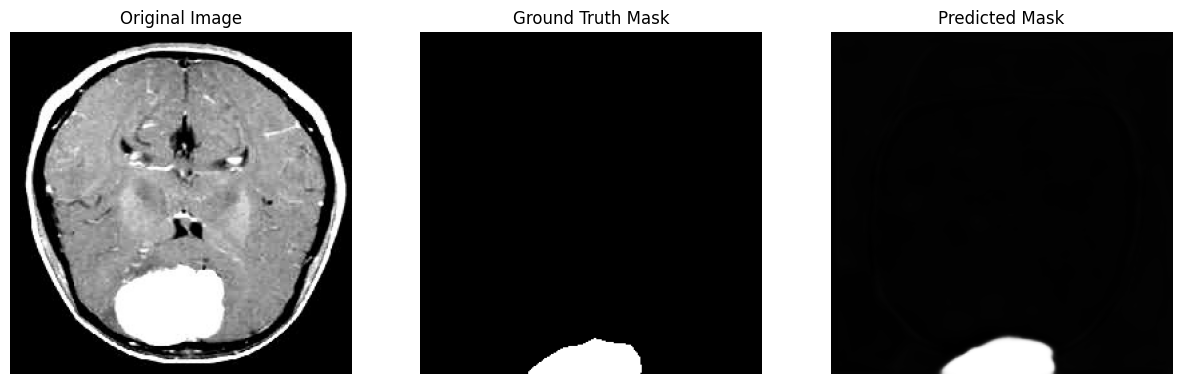

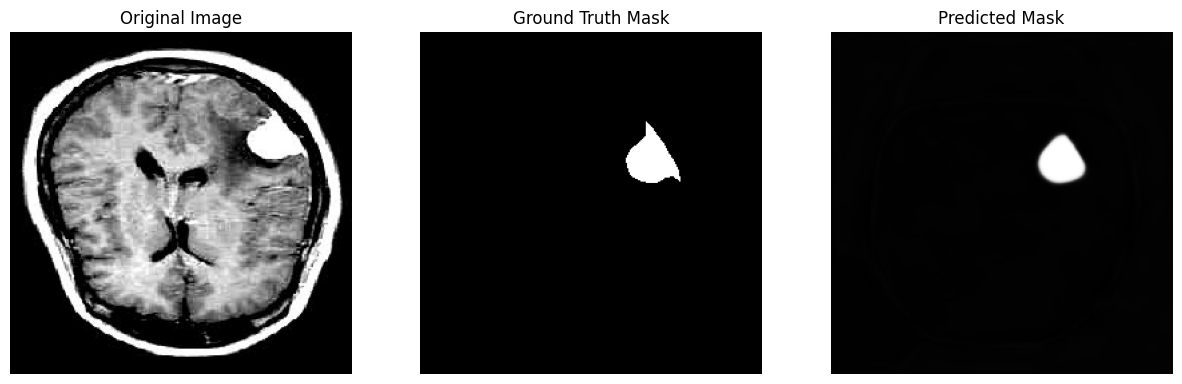

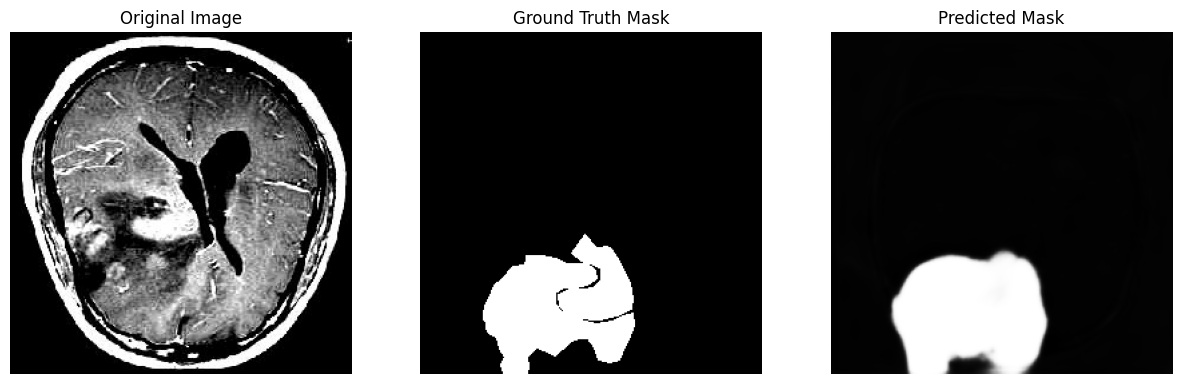

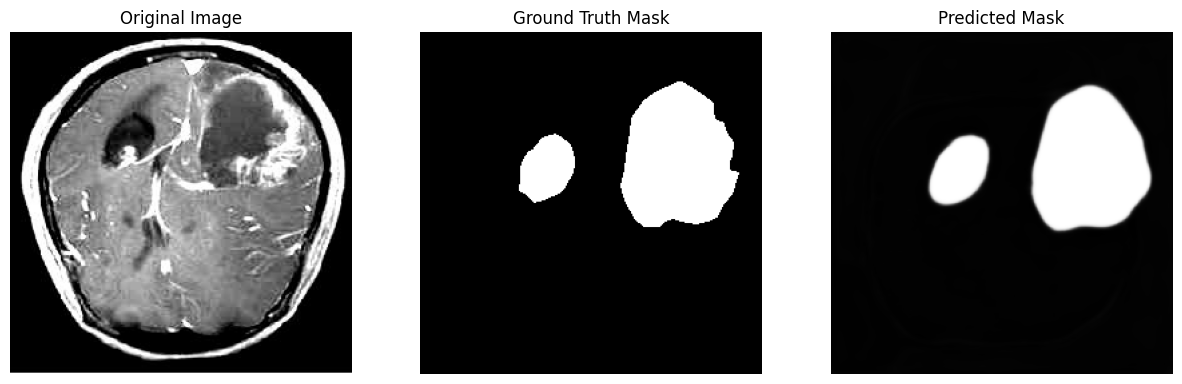

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 389ms/step


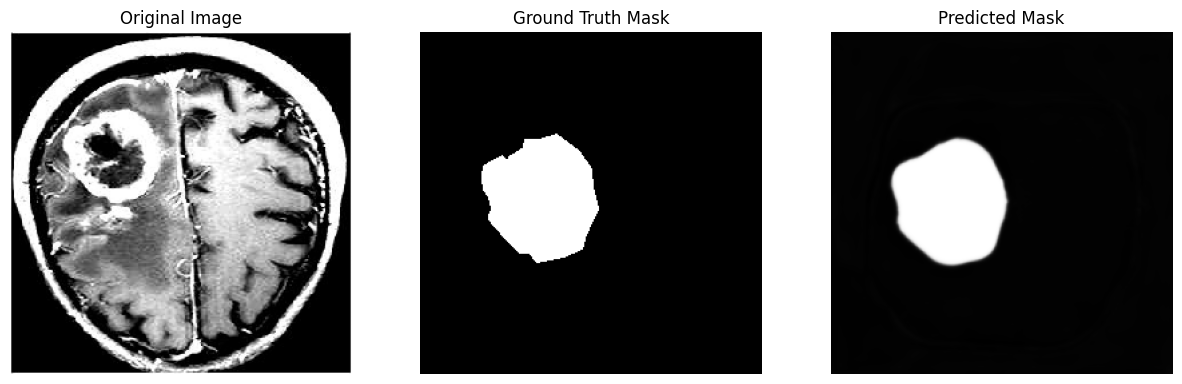

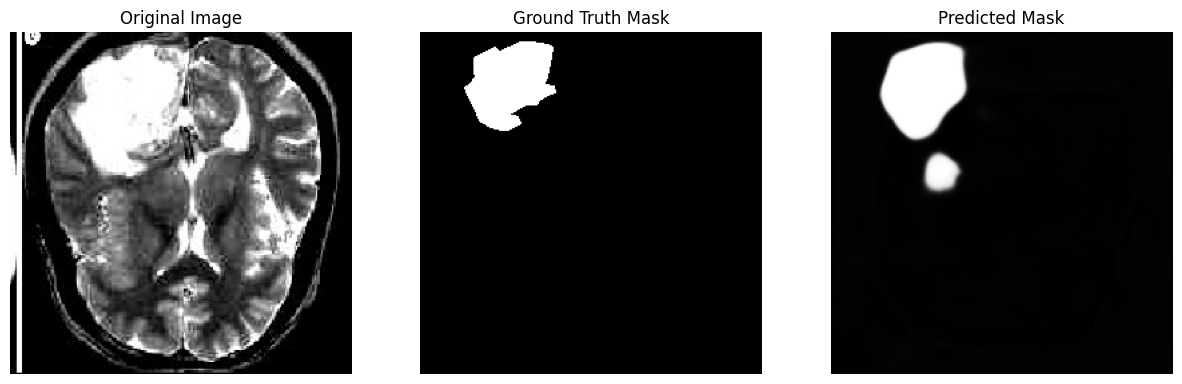

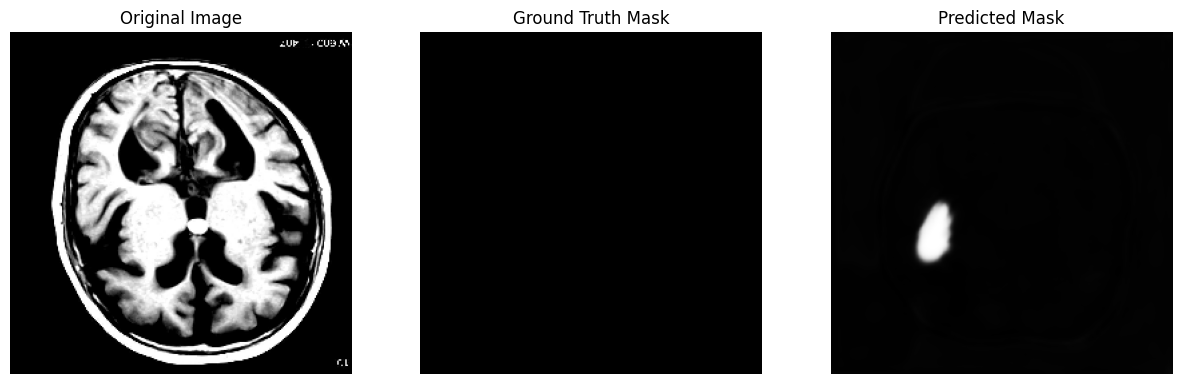

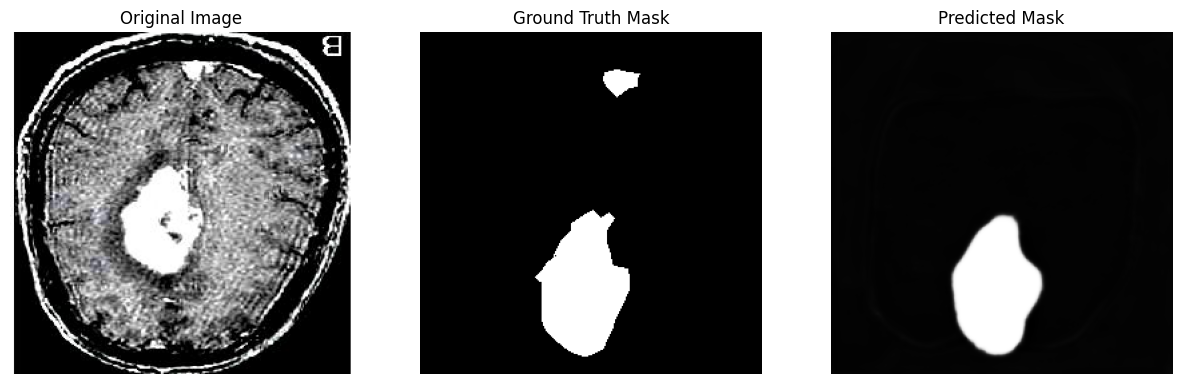

In [13]:
import matplotlib.pyplot as plt  

# Visualize predictions for the training set

print("Visualizing predictions for the training set:")
visualize_predictions(model, train_dataset)


Visualizing predictions for the validation set:
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 365ms/step


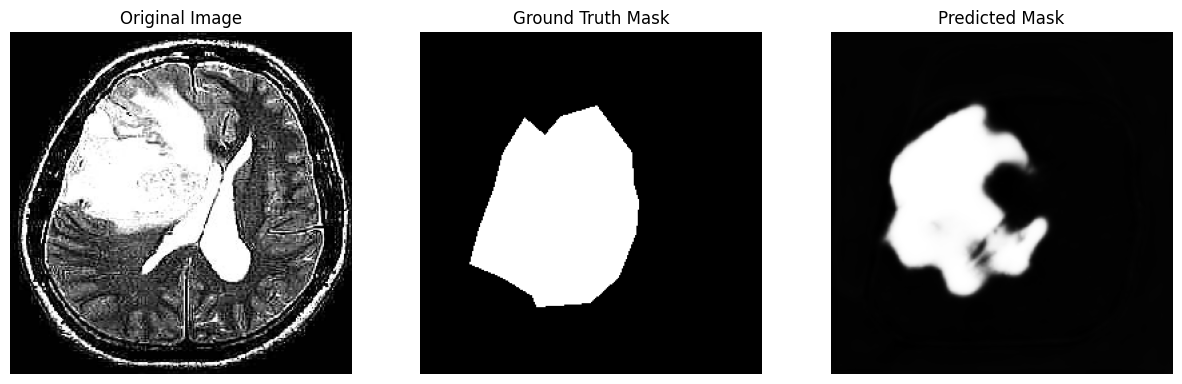

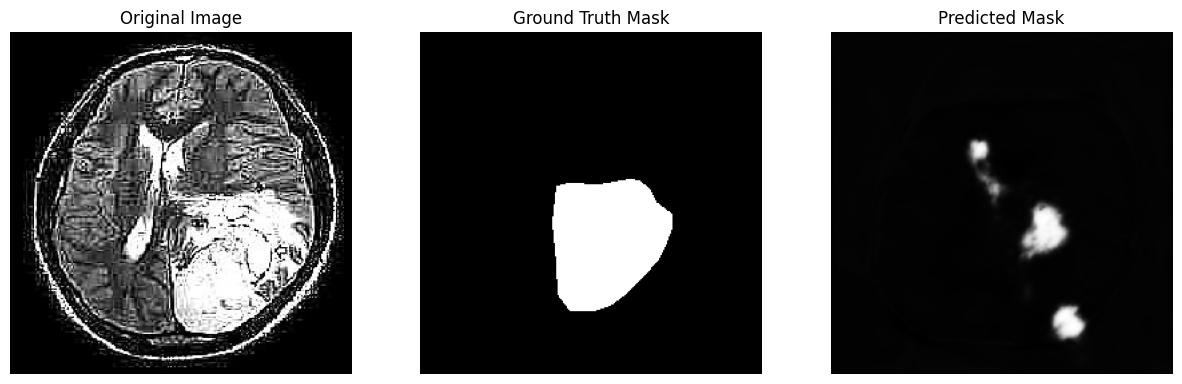

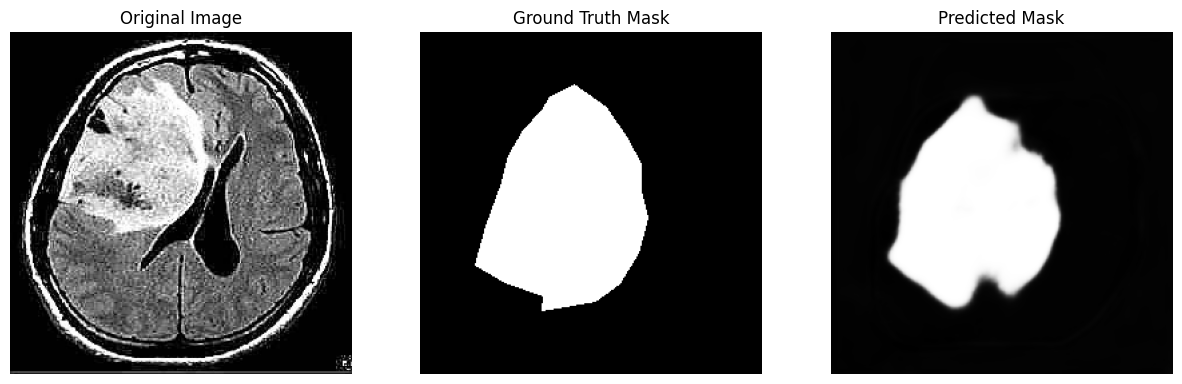

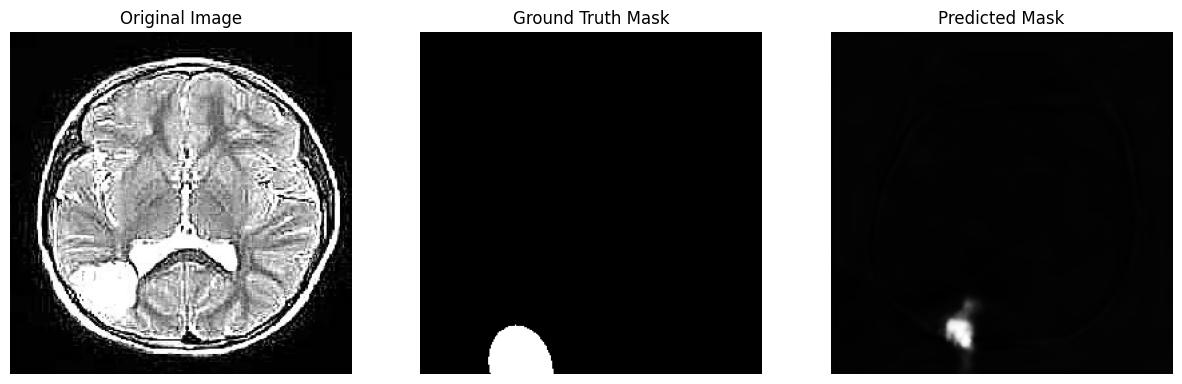

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 406ms/step


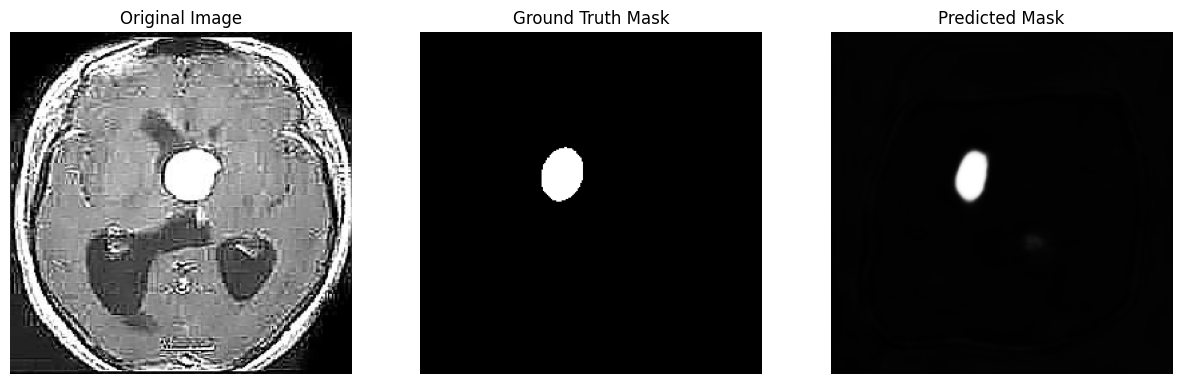

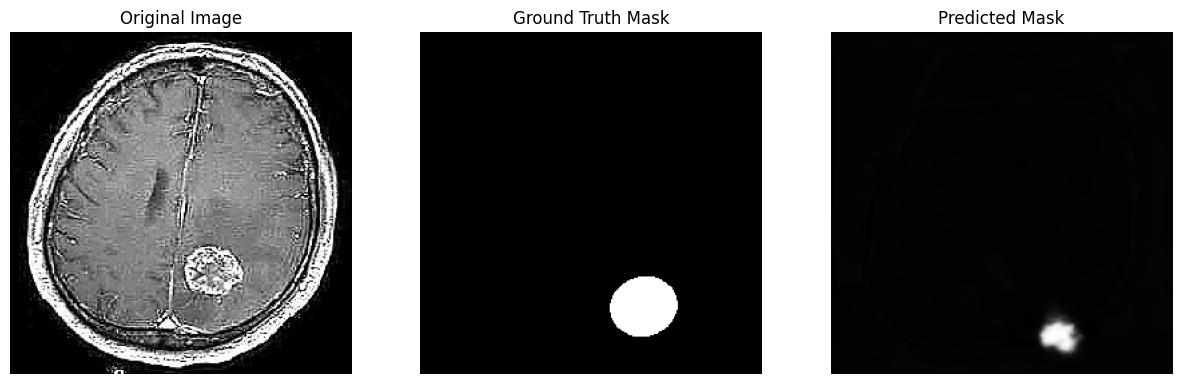

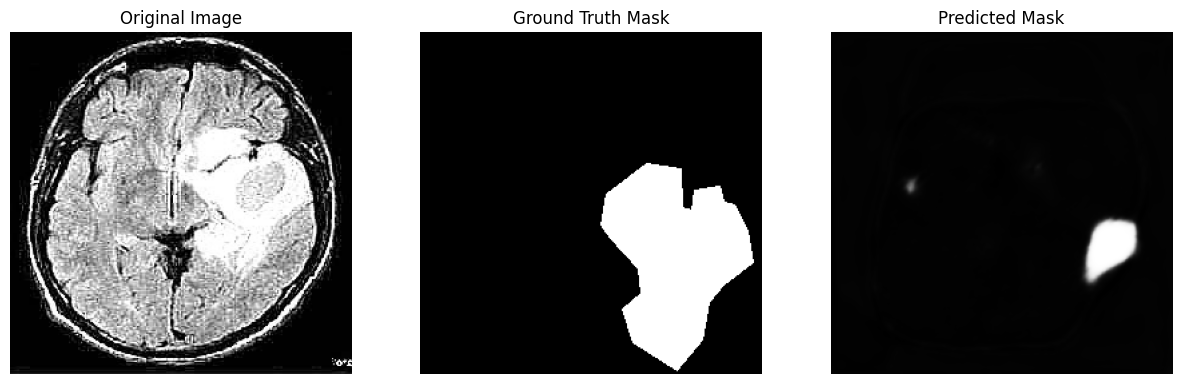

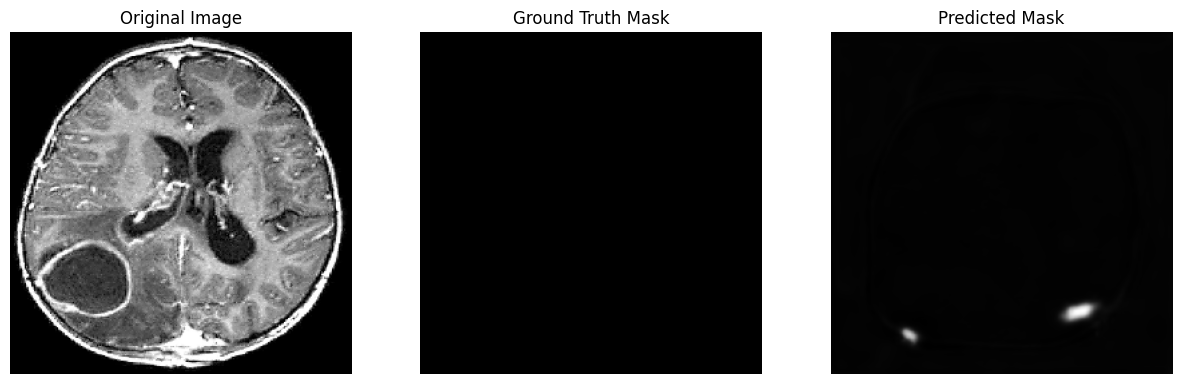

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step


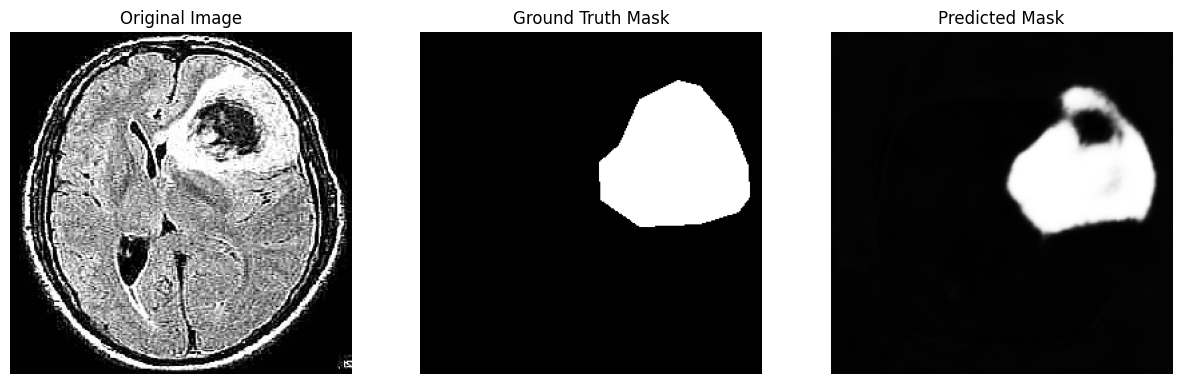

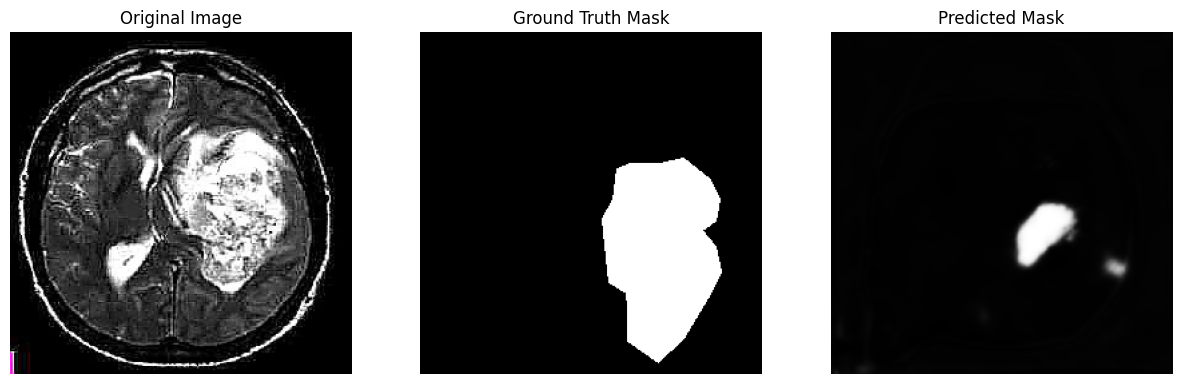

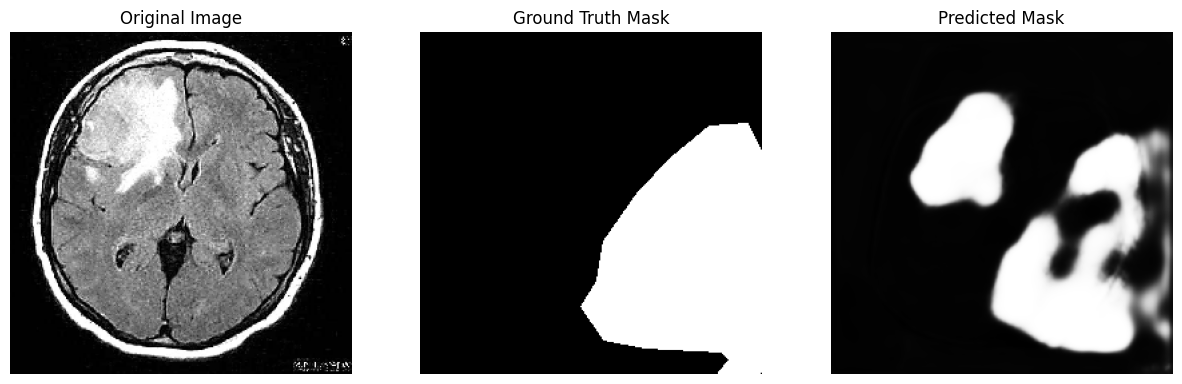

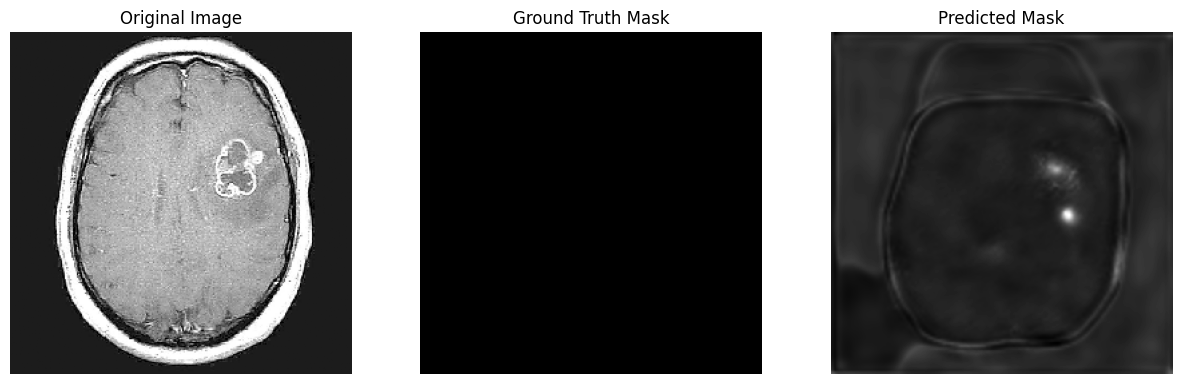

In [14]:
# Visualize predictions for the test set
print("Visualizing predictions for the test set:")
visualize_predictions(model, test_dataset)

In [11]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = tf.keras.backend.flatten(y_true)
    y_pred_f = tf.keras.backend.flatten(y_pred)
    intersection = tf.keras.backend.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (tf.keras.backend.sum(y_true_f) + tf.keras.backend.sum(y_pred_f) + smooth)

# Use this custom metric when compiling the model
model.compile(optimizer=optimizer, loss=bce_dice_loss, metrics=[iou_metric, accuracy_metric, dice_coefficient])

# Model training
history = model.fit(train_dataset, epochs=num_epochs, validation_data=val_dataset)

# Extract the final Dice coefficient value for training and validation
Dice Coefficient = history.history['dice_coefficient'][-1]

print(f'Final Training Dice Coefficient: {Dice Coefficient}')

Dice Coefficient: 0.8666666865348815
